In [1]:
from ds.physio.general import PhysioNetClinicalDataset
import warnings, torch, os
import pandas as pd
import torch.utils.data as data
from utils.train import get_dataloader_g, collate_fn
from utils.device import clean_memory_get_device
from utils.plot import plot_train
from our_alt.builder import OurApproachAlt
import math
import numpy as np
from IPython.display import clear_output
from torchvision import models

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device()
# device = torch.device("cpu")
# reproducibility()
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large 

In [3]:
image_size = 128
batch_size = 128
epochs = 200

train_d = data.DataLoader(
    PhysioNetClinicalDataset(split_str="train", image_size=image_size),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    generator=get_dataloader_g(0),
    drop_last=False,
)

In [4]:
learner = OurApproachAlt(
    models.resnet18,
    clinical_input_dim=train_d.dataset.num_clinical_features(),
    image_size=image_size,
    # hidden_layer="avgpool",  # layer name where output is hidden dimension. this can also be an integer specifying the index of the child
    # project_hidden=True,  # use projection head
    dim=512,  # output size of resnet18, to match size in the simclr.
    pred_dim=128,
)

In [5]:
# # load 100 epoch model
# cp = torch.load(os.path.join("checkpoints", "our_alt", "model"), map_location=device)
# learner.load_state_dict(cp["model"], strict=True)

In [6]:
def get_number(x):
    try:
        return float(x)
    except:
        return None

In [7]:
optimizer = torch.optim.AdamW(
    params=[p for p in learner.parameters() if p.requires_grad],
    lr=3e-4,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=math.ceil(len(train_d.dataset) / batch_size)
    * epochs,  # 286,817 is the size of the training dataset. (https://paperswithcode.com/dataset/cnn-daily-mail-1)
    eta_min=1e-8,
)

In [8]:
def train_one_epoch(
    model,
    optimizer,
    data_loader,
    device,
    epoch,
    max_norm=0,
    lr_scheduler=None,
):
    model.to(device)
    model.train()
    iters = math.ceil(len(data_loader.dataset) / train_d.batch_size)

    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, iters - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    losses = []

    for i, (img, tab) in enumerate(data_loader):
        loss = model(img.to(device), tab.to(device))
        optimizer.zero_grad()
        loss.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        if lr_scheduler is not None:
            if isinstance(
                lr_scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
            ):
                lr_scheduler.step(epoch + i / iters)
            else:
                lr_scheduler.step()
        losses.append(loss.item())
    return losses

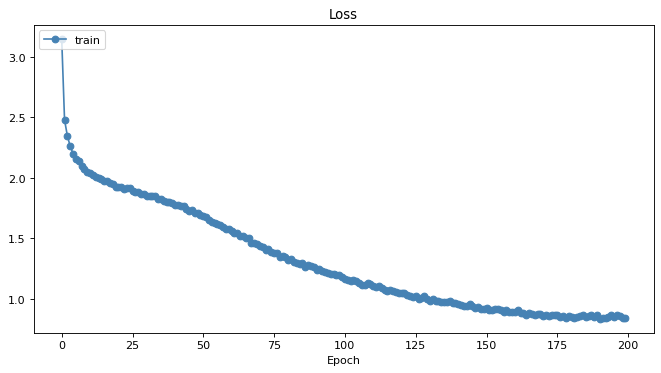

In [9]:
train_losses = []
for epoch in range(epochs):
    train_l = train_one_epoch(
        learner,
        optimizer,
        train_d,
        device,
        epoch,
        max_norm=1,
        lr_scheduler=scheduler,
    )
    train_losses.append(np.mean(train_l))
    clear_output()
    plot_train(train_losses, title="Loss")

In [10]:
model_path = "our_alt_200" # see if improved what if in 500 epochs?

saving_dict = {"model": learner.state_dict()}
if optimizer:
    saving_dict["optimizer"] = optimizer.state_dict()

saving_folder = os.path.join("checkpoints", model_path)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs(saving_folder, exist_ok=True)
torch.save(
    saving_dict,
    os.path.join("checkpoints", model_path, "model"),
)

# learner.net.net.state_dict() # resnet here.